In [571]:
import pandas as pd
import requests, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime, timedelta

### 自動生成 24 個月份的列表，從 2021 年 1 月開始

In [572]:
def generate_date_list(start_date, months):
    date_list = []
    start = datetime.strptime(start_date, "%Y%m%d")
    for i in range(months):
        year_month = start + timedelta(days=30 * i)  # 每次增加一個月
        date_str = year_month.strftime("%Y%m01")  # 每個月的第一天
        date_list.append(date_str)
    return date_list

### 下載證交所資料

In [573]:
def fetch_data(date, stock_no):
    url = f'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={stock_no}'
    html = requests.get(url,verify=False)
    content = json.loads(html.text)
    stock_data = content['data']
    col_name = content['fields']
    df = pd.DataFrame(data=stock_data, columns=col_name)
    return df

### 將民國年轉換為西元年

In [574]:
def convert_minguo_to_ad(date_str):
    year, month, day = date_str.split('/')
    year = str(int(year) + 1911)
    return f'{year}-{month}-{day}'

### 爬取證交所 2330.tw 股價

In [575]:
# 生成 36 個月份的日期列表
date_list = generate_date_list('20200601', 48)
stock_no = '2330'
df_list = []

for date in date_list:
    df = fetch_data(date, stock_no)
    df_list.append(df)

# 將多個月份的資料合併，只使用前 35 個月資料
df_twse = pd.concat(df_list[:-1])

# 將日期轉換為西元年
df_twse['日期'] = df_twse['日期'].apply(convert_minguo_to_ad)
# 轉換為 datetime 格式並設置為索引
df_twse['日期'] = pd.to_datetime(df_twse['日期'], format='%Y-%m-%d')
df_twse.set_index('日期', inplace=True)

df_twse.tail()

d:\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
d:\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
d:\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
d:\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverif

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
日期,,,,,,,,
2024-03-25,"21,223,414","16,612,693,369",783.00,788.00,779.00,780.00,-5.00,"24,794"
2024-03-26,"43,103,294","33,847,261,033",788.00,792.00,776.00,782.00,+2.00,"35,046"
2024-03-27,"19,732,209","15,418,346,943",785.00,785.00,779.00,779.00,-3.00,"21,006"
2024-03-28,"28,393,398","21,889,883,699",774.00,776.00,768.00,769.00,-10.00,"39,848"
2024-03-29,"20,212,820","15,682,908,766",769.00,781.00,768.00,779.00,+10.00,"18,110"


### 修正表格部分欄位資料型態並轉換為數字型態

In [576]:
for i in list(df_twse):
    if i != '日期' and type(df_twse[i][0]) == str:
        df_twse[i] = pd.to_numeric(df_twse[i].str.replace(',', ''), errors='coerce')

C:\Users\謝孟達\AppData\Local\Temp\ipykernel_4176\2331691336.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if i != '日期' and type(df_twse[i][0]) == str:


### 1. 計算技術指標（SMA、RSI、MACD）

In [577]:
# RSI 計算
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [578]:
# 計算SMA (簡單移動平均)
df_twse['SMA_20'] = df_twse['收盤價'].rolling(window=20).mean()

# 計算 RSI
df_twse['RSI_14'] = calculate_rsi(df_twse['收盤價'])

# 計算MACD
short_window = 12
long_window = 26
signal_window = 9
df_twse['EMA12'] = df_twse['收盤價'].ewm(span=short_window, adjust=False).mean()
df_twse['EMA26'] = df_twse['收盤價'].ewm(span=long_window, adjust=False).mean()
df_twse['MACD'] = df_twse['EMA12'] - df_twse['EMA26']
df_twse['MACD_Signal'] = df_twse['MACD'].ewm(span=signal_window, adjust=False).mean()
df_twse.tail()

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,SMA_20,RSI_14,EMA12,EMA26,MACD,MACD_Signal
日期,,,,,,,,,,,,,,
2024-03-25,21223414,16612693369,783.0,788.0,779.0,780.0,-5.0,24794,749.70,64.705882,765.083765,735.688622,29.395143,31.279271
2024-03-26,43103294,33847261033,788.0,792.0,776.0,782.0,2.0,35046,753.90,64.071856,767.686263,739.119094,28.567169,30.736851
2024-03-27,19732209,15418346943,785.0,785.0,779.0,779.0,-3.0,21006,757.95,56.551724,769.426838,742.073235,27.353602,30.060201
2024-03-28,28393398,21889883699,774.0,776.0,768.0,769.0,-10.0,39848,761.90,44.274809,769.361170,744.067811,25.293360,29.106833
2024-03-29,20212820,15682908766,769.0,781.0,768.0,779.0,10.0,18110,766.40,55.284553,770.844067,746.655380,24.188687,28.123204


In [579]:
# 將欄位名稱改為英文
df_twse.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '收盤價': 'Close', '成交筆數': 'Volume'}, inplace=True)
# 移除有 NaN 值的列
df_twse.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)

In [580]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### 切分訓練與測試資料

In [581]:
feature_x = ['SMA_20', 'RSI_14', 'MACD', 'MACD_Signal']

# 移除 NaN 值
df_twse.dropna(subset=feature_x, inplace=True)

# 建立未來一天的股價作為目標變量
df_twse['Future_Price'] = df_twse['Close'].shift(-1)
# 使用第36個月的第一個資料填補最後一天空值
df_36th_month = df_list[-1]
first_price_of_36th_month = float(df_36th_month.iloc[0]['收盤價'].replace(',', ''))
df_twse['Future_Price'].iloc[-1] = first_price_of_36th_month

# 準備特徵和標籤
X = df_twse[feature_x]
y = df_twse['Future_Price'].values.reshape(-1, 1)

# scaler = MinMaxScaler(feature_range=(0, 3))
# X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y)

# X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# 分割資料為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # 保留時間順序
)

C:\Users\謝孟達\AppData\Local\Temp\ipykernel_4176\2302866345.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_twse['Future_Price'].iloc[-1] = first_price_of_36th_month
C:\Users\謝孟達\AppData\Local\Temp\ipykernel_4176\2302866345.py:11: Sett

In [582]:
import torch
import torch.nn as nn
import torch.optim as optim

In [583]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, hidden_size3, output_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc4(out)
        # out = self.sigmoid(out)
        return out

In [584]:
input_size = len(feature_x)
hidden_size = 256
hidden_size2 = 512
hidden_size3 = 1024
output_size = 1
learning_rate = 0.0005
num_epochs = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

model = ANN(input_size, hidden_size, hidden_size2, hidden_size3, output_size).to(device)

# 4. 定義損失函數和優化器
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 5. 訓練模型
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_t)
    loss = loss_fn(outputs, y_train_t)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 850.0974
Epoch [200/10000], Loss: 677.7396
Epoch [300/10000], Loss: 600.1644
Epoch [400/10000], Loss: 587.0801
Epoch [500/10000], Loss: 570.0888
Epoch [600/10000], Loss: 623.6411
Epoch [700/10000], Loss: 582.1832
Epoch [800/10000], Loss: 553.2785
Epoch [900/10000], Loss: 553.7623
Epoch [1000/10000], Loss: 536.2952
Epoch [1100/10000], Loss: 600.7409
Epoch [1200/10000], Loss: 496.7442
Epoch [1300/10000], Loss: 553.9951
Epoch [1400/10000], Loss: 510.5144
Epoch [1500/10000], Loss: 506.9933
Epoch [1600/10000], Loss: 512.5417
Epoch [1700/10000], Loss: 492.5838
Epoch [1800/10000], Loss: 504.0992
Epoch [1900/10000], Loss: 570.6149
Epoch [2000/10000], Loss: 540.4833
Epoch [2100/10000], Loss: 520.0660
Epoch [2200/10000], Loss: 489.6080
Epoch [2300/10000], Loss: 553.5776
Epoch [2400/10000], Loss: 516.2933
Epoch [2500/10000], Loss: 540.0958
Epoch [2600/10000], Loss: 566.9163
Epoch [2700/10000], Loss: 575.4927
Epoch [2800/10000], Loss: 518.3604
Epoch [2900/10000], Loss: 618

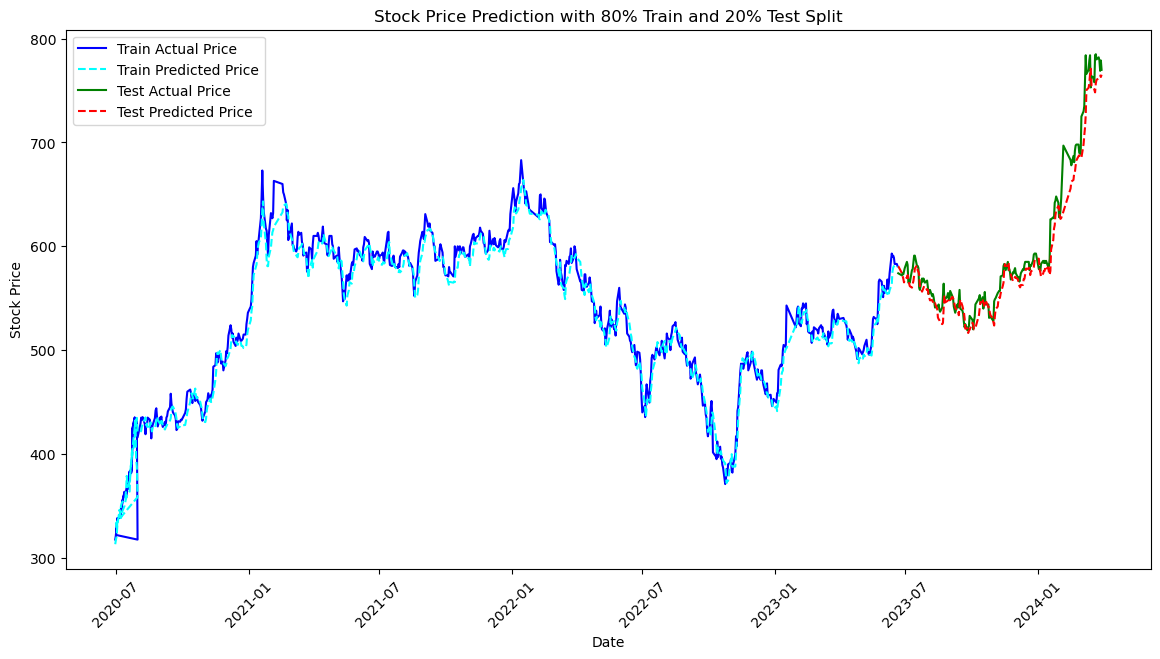

In [586]:
import matplotlib.pyplot as plt

# 假設 'Date' 列在原始 X_df 中
split_index = int(len(df_twse.index) * 0.8)
date_train = df_twse.index[:split_index]
date_test = df_twse.index[split_index:]

# 預測結果準備
model.eval()
with torch.no_grad():
    predicted_train = model(X_train_t).cpu().detach().numpy()
    predicted_test = model(X_test_t).cpu().detach().numpy()

# 繪圖
plt.figure(figsize=(14, 7))

# 繪製訓練集的實際值和預測值
plt.plot(date_train, y_train, label='Train Actual Price', color='blue')
plt.plot(date_train, predicted_train, label='Train Predicted Price', color='cyan', linestyle='--')

# 繪製測試集的實際值和預測值
plt.plot(date_test, y_test, label='Test Actual Price', color='green')
plt.plot(date_test, predicted_test, label='Test Predicted Price', color='red', linestyle='--')

# 標籤和圖例
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with 80% Train and 20% Test Split')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [587]:
from sklearn.metrics import mean_absolute_error, r2_score

# 計算 MAE 和 R2
mae_train = mean_absolute_error(y_train, predicted_train)
r2_train = r2_score(y_train, predicted_train)
mae_test = mean_absolute_error(y_test, predicted_test)
r2_test = r2_score(y_test, predicted_test)

print(f"Train MAE: {mae_train:.4f}, Train R2: {r2_train:.4f}")
print(f"Test MAE: {mae_test:.4f}, Test R2: {r2_test:.4f}")

Train MAE: 8.8748, Train R2: 0.9775
Test MAE: 10.4964, Test R2: 0.9599
